# I. Monthly data

# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima.arima import auto_arima

In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
data = pd.read_excel('data.xlsx')

In [4]:
data.set_index(pd.to_datetime(data[["YEAR", "MONTH"]].assign(DAY=1)), inplace = True)

In [5]:
data.drop(['YEAR','MONTH','HANSGN'], axis = 1, inplace = True)

In [6]:
data.head(5)

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993


<AxesSubplot:>

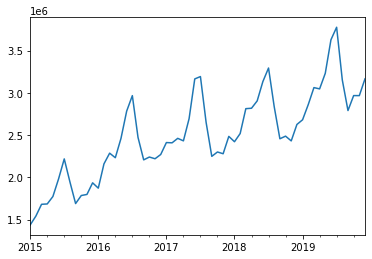

In [7]:
data['TTT'].plot()

In [8]:
train = data[:-12].copy()
test = data[-12:].copy() # last 12 months as test set

In [9]:
test

,TTT
2019-01-01,2680573
2019-02-01,2860436
2019-03-01,3061302
2019-04-01,3045879
2019-05-01,3230488
2019-06-01,3627333
2019-07-01,3775263
2019-08-01,3151724
2019-09-01,2789760
2019-10-01,2966733


# 2. Time Series Analysis

In [10]:
# Stationarity test:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.968342
Critical Values at 0.05: -2.94
p-value: 0.001586
Stationary


In [11]:
kpss_test = kpss(train)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.795515
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:>

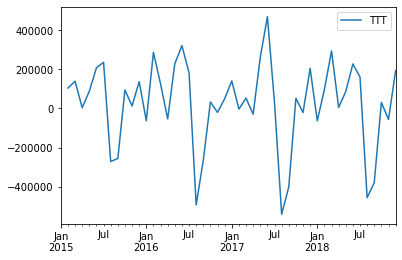

In [12]:
train1 = train - train.shift(1)
train1.plot()

In [13]:
# unit-root ("difference stationary") test:
# Difference-stationary: If a time series can be made stationary by differencing, it is said to contain a unit root.
# In essence, this means that the current value of a series yt is equal to its last value yt−1 plus an error ϵt
# i.e. yt=ayt−1+ϵt with |a|=1
# Variables that show this behaviour are also said to be integrated of order d, or I(d)
# which means that d differences are neccesary to render a series stationary.
result = adfuller(train1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -6.515841
p-value: 0.000000
Stationary


In [14]:
# trend-stationary test:
kpss_test = kpss(train1.dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.071539
Critical Values @ 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


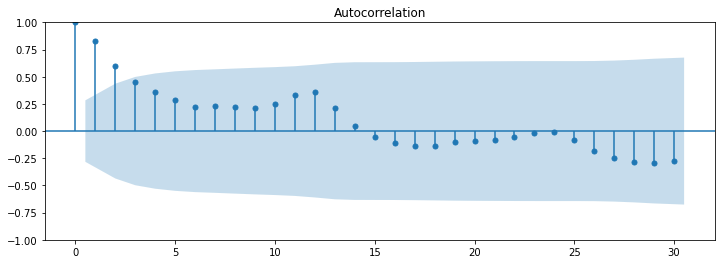

In [15]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(train, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


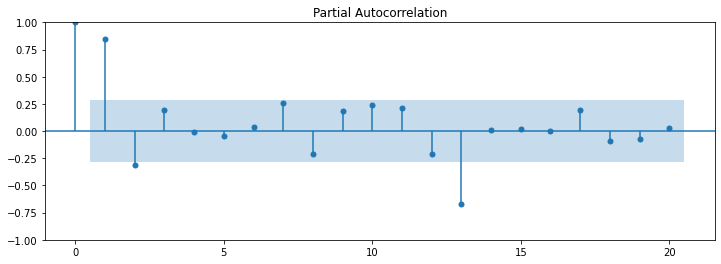

In [16]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 1 differencing, d value should be 1
- Based on ACF plot, q value should be 3
- Based on PACF plot, p value should be 1

# 3. Build models

## 3.1. SARIMA without boxcox

In [17]:
model = auto_arima(train,
                   d = None, max_d = 4,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True, random_state = 99)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=924.288, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=927.295, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=924.722, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=924.927, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=924.383, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=923.980, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=946.087, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=926.278, Time=0.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=924.632, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=925.333, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=925.632, Time=0.03 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 1.039 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -459.990
Date:                            Wed, 08 Feb 2023   AIC                            923.980
Time:                                    16:17:10   BIC                            927.090
Sample:                                01-01-2015   HQIC                           925.053
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1396      0.118     -1.181      0.237      -0.371       0.092
sigma2       1.37e+10   1.17e-13   1.17e+23      0.000    1.37e+10    1.37e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.54   Prob(JB):                         0.85
Heteroskedasticity (H):               1.14   Skew:                            -0.14
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [18]:
# Predict using the best model from auto_arima:
test['predict'] = pd.Series(model.predict(12).astype('int64'))

In [19]:
test

,TTT,predict
2019-01-01,2680573,2590299
2019-02-01,2860436,2672974
2019-03-01,3061302,2933866
2019-04-01,3045879,2933991
2019-05-01,3230488,3045351
2019-06-01,3627333,3307231
2019-07-01,3775263,3449552
2019-08-01,3151724,2980691
2019-09-01,2789760,2597626
2019-10-01,2966733,2631500


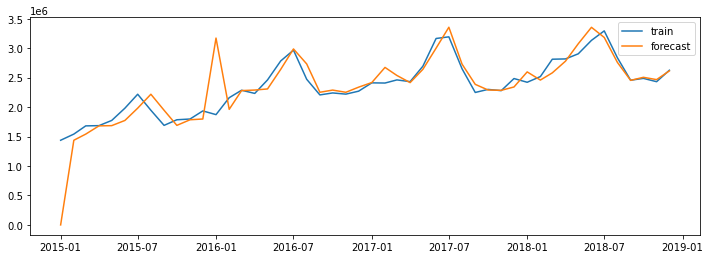

In [20]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='train')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

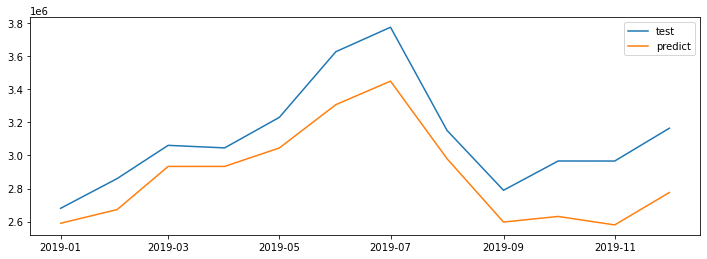

In [21]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [22]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)

In [23]:
results = pd.DataFrame({'Method':'SARIMA', 'MAPE': [mape], 'RMSE': [rmse]})
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"


## 3.2. SARIMA with boxcox (trend stationary)

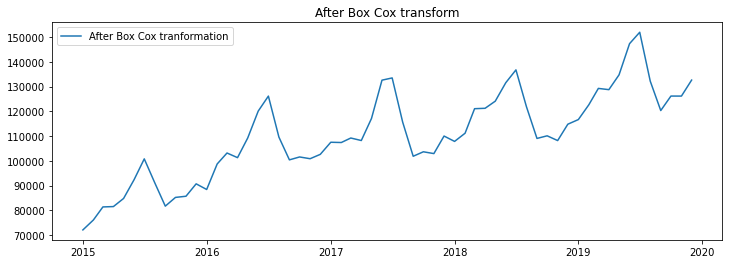

In [24]:
data_boxcox = pd.Series(boxcox(data['TTT'])[0], index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [25]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -2.315488
Critical Values at 0.05: -2.92
p-value: 0.167021
Not stationary


In [26]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 1.059631
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


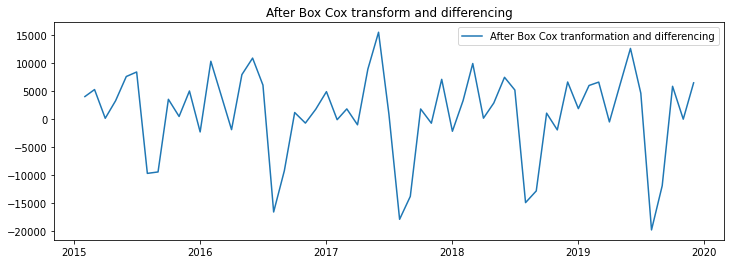

In [27]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [28]:
data_boxcox_diff.dropna(inplace=True)

In [29]:
# Stationarity test:
result = adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -1.697966
Critical Values at 0.05: -2.93
p-value: 0.432161
Not stationary


In [30]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.049471
Critical Values at 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


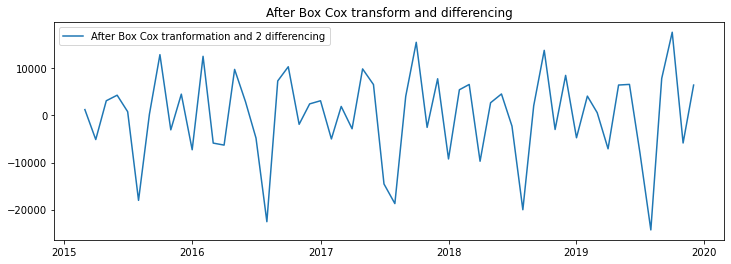

In [31]:
data_boxcox_diff2 = pd.Series(data_boxcox_diff - data_boxcox_diff.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff2, label='After Box Cox tranformation and 2 differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [32]:
data_boxcox_diff2.dropna(inplace=True)

In [33]:
# Stationarity test:
result = adfuller(data_boxcox_diff2)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -10.868264
Critical Values at 0.05: -2.93
p-value: 0.000000
Stationary


In [34]:
kpss_test = kpss(data_boxcox_diff2)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.362500
Critical Values at 0.05: 0.46
p-value: 0.093319
Stationary


In [35]:
data_boxcox_diff2.tail()

2019-08-01                -24,334
2019-09-01                  7,867
2019-10-01                 17,698
2019-11-01                 -5,850
2019-12-01                  6,465
dtype: float64

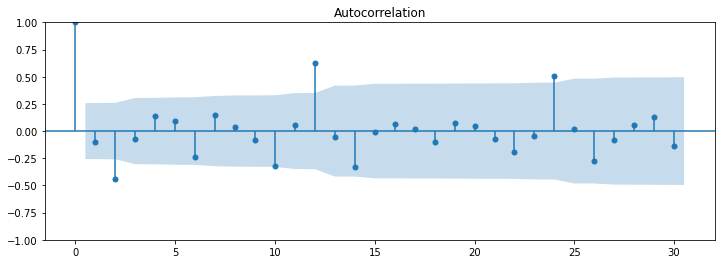

In [36]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff2, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


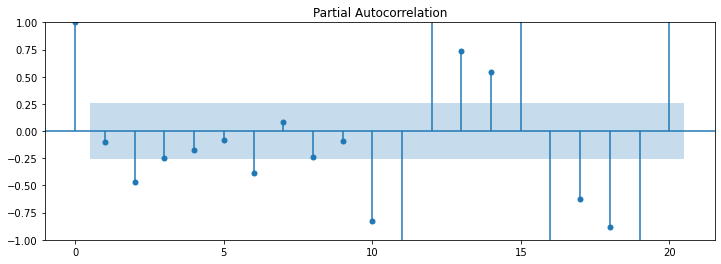

In [37]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff2, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 2 differencing, d value should be 2
- Based on ACF plot, q value should be 0
- Based on PACF plot, p value should be 2

In [38]:
train_data_boxcox = data_boxcox[:-12]
test_data_boxcox = data_boxcox[-12:]

In [39]:
test_data_boxcox

2019-01-01                116,660
2019-02-01                122,647
2019-03-01                129,232
2019-04-01                128,730
2019-05-01                134,702
2019-06-01                147,282
2019-07-01                151,890
2019-08-01                132,164
2019-09-01                120,305
2019-10-01                126,144
2019-11-01                126,134
2019-12-01                132,589
dtype: float64

In [40]:
model = auto_arima(train_data_boxcox,
                   d = None, max_d = 4,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True, random_state = 99)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=686.362, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=688.344, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=686.729, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=687.050, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=686.787, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=686.380, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=688.665, Time=0.35 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=687.240, Time=0.16 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=686.941, Time=0.28 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=687.206, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=687.290, Time=0.18 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=688.485, Time=0.28 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -340.181
Date:                              Wed, 08 Feb 2023   AIC                            686.362
Time:                                      16:17:17   BIC                            691.028
Sample:                                  01-01-2015   HQIC                           687.972
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9234      1.643     -0.562      0.574      -4.145       2.298
ma.S.L12       0.8747      1.887      0.464      0.643      -2.823       4.572
sigma2      1.602e+07   7.65e-07   2.09e+13      0.000     1.6e+07     1.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.36   Prob(JB):                         0.83
Heteroskedasticity (H):               1.28   Skew:                            -0.25
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.11e+28. Standard errors may be unstable.
"""

In [41]:
# Predict using the best model from auto_arima:
# data['TTT']
# inv_boxcox(boxcox(data['TTT'])[0],boxcox(data['TTT'])[1])
test['predict_boxcox'] = pd.Series(model.predict(12).astype('int64'))
test['predict'] = inv_boxcox(test['predict_boxcox'],boxcox(data['TTT'])[1])

In [42]:
test

,TTT,predict,predict_boxcox
2019-01-01,2680573,"2,746,124",118852
2019-02-01,2860436,"2,820,499",121325
2019-03-01,3061302,"3,112,306",130888
2019-04-01,3045879,"3,119,620",131125
2019-05-01,3230488,"3,217,742",134292
2019-06-01,3627333,"3,476,755",142548
2019-07-01,3775263,"3,639,467",147662
2019-08-01,3151724,"3,162,290",132505
2019-09-01,2789760,"2,752,572",119067
2019-10-01,2966733,"2,793,770",120438


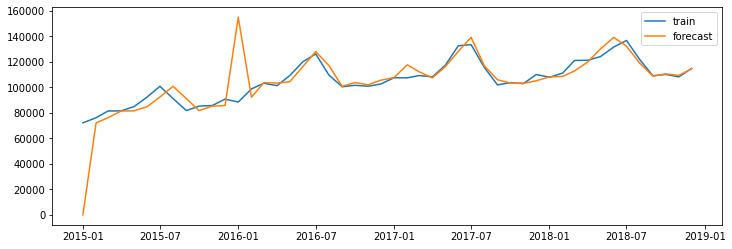

In [43]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train_data_boxcox, label='train')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

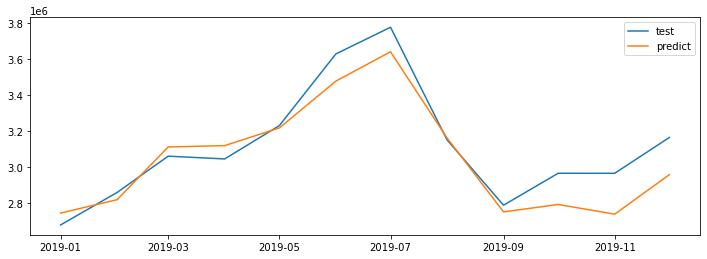

In [44]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [45]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)
tempResults = pd.DataFrame({'Method':'SARIMA with boxcox', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"


## 3.3. Prophet

In [46]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [47]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [48]:
help(Prophet.fit)

Help on function fit in module prophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet object.

In [49]:
data.head(5)

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993


In [50]:
data['date'] = data.index

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TTT     60 non-null     int64         
 1   date    60 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [52]:
data = data.rename(columns={'date': 'ds', 'TTT': 'y'})

In [53]:
train = data[:-12].copy()
test = data[-12:].copy() # last 12 months as test set

In [54]:
# set the uncertainty interval to 90% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.9)

In [55]:
my_model.fit(train)

16:17:20 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

,ds
55,2019-08-01
56,2019-09-01
57,2019-10-01
58,2019-11-01
59,2019-12-01


In [57]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
48,2019-01-01,"2,621,989","2,514,920","2,721,087"
49,2019-02-01,"2,762,466","2,662,418","2,867,195"
50,2019-03-01,"2,900,542","2,794,526","3,000,274"
51,2019-04-01,"2,919,307","2,809,507","3,020,988"
52,2019-05-01,"2,997,933","2,900,141","3,096,508"
53,2019-06-01,"3,211,643","3,110,432","3,317,473"
54,2019-07-01,"3,391,835","3,289,453","3,499,260"
55,2019-08-01,"3,028,472","2,914,864","3,134,789"
56,2019-09-01,"2,670,088","2,559,228","2,785,243"
57,2019-10-01,"2,703,863","2,591,987","2,811,885"


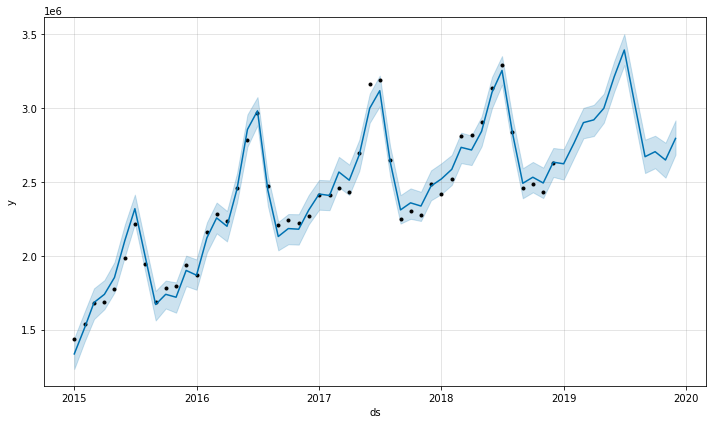

In [58]:
fig = my_model.plot(forecast, uncertainty=True)

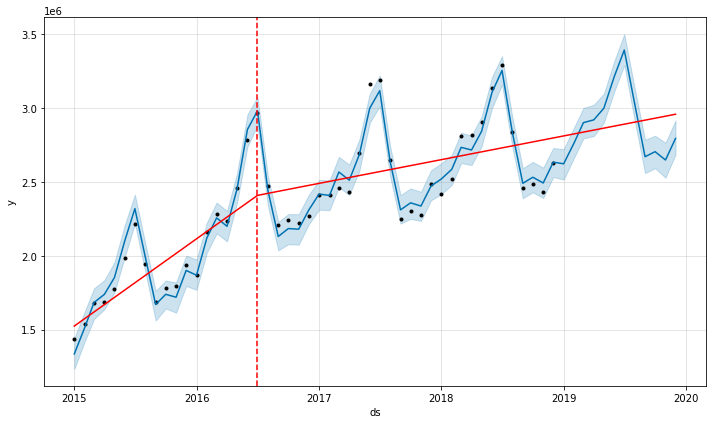

In [59]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [60]:
my_model.changepoints

1    2015-02-01
3    2015-04-01
4    2015-05-01
6    2015-07-01
7    2015-08-01
9    2015-10-01
10   2015-11-01
12   2016-01-01
13   2016-02-01
15   2016-04-01
16   2016-05-01
18   2016-07-01
19   2016-08-01
21   2016-10-01
22   2016-11-01
24   2017-01-01
25   2017-02-01
27   2017-04-01
28   2017-05-01
30   2017-07-01
31   2017-08-01
33   2017-10-01
34   2017-11-01
36   2018-01-01
37   2018-02-01
Name: ds, dtype: datetime64[ns]

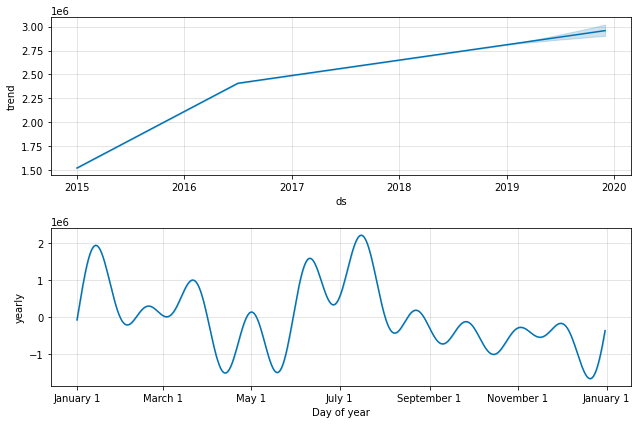

In [61]:
fig2 = my_model.plot_components(forecast)

In [62]:
forecast.set_index('ds',inplace=True)

In [63]:
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2015-01-01,"1,523,904","1,233,102","1,442,677","1,523,904","1,523,904","-188,519","-188,519","-188,519","-188,519","-188,519","-188,519",0,0,0,"1,335,386"
2015-02-01,"1,574,044","1,419,206","1,621,110","1,574,044","1,574,044","-61,666","-61,666","-61,666","-61,666","-61,666","-61,666",0,0,0,"1,512,378"
2015-03-01,"1,619,332","1,571,372","1,779,365","1,619,332","1,619,332","64,103","64,103","64,103","64,103","64,103","64,103",0,0,0,"1,683,436"
2015-04-01,"1,669,472","1,638,114","1,835,184","1,669,472","1,669,472","69,244","69,244","69,244","69,244","69,244","69,244",0,0,0,"1,738,716"
2015-05-01,"1,717,995","1,750,991","1,956,237","1,717,995","1,717,995","134,684","134,684","134,684","134,684","134,684","134,684",0,0,0,"1,852,679"
2015-06-01,"1,768,135","1,993,367","2,210,919","1,768,135","1,768,135","334,770","334,770","334,770","334,770","334,770","334,770",0,0,0,"2,102,905"
2015-07-01,"1,816,658","2,216,429","2,413,408","1,816,658","1,816,658","501,777","501,777","501,777","501,777","501,777","501,777",0,0,0,"2,318,434"
2015-08-01,"1,866,798","1,891,469","2,084,598","1,866,798","1,866,798","124,789","124,789","124,789","124,789","124,789","124,789",0,0,0,"1,991,587"
2015-09-01,"1,916,938","1,561,545","1,761,924","1,916,938","1,916,938","-247,220","-247,220","-247,220","-247,220","-247,220","-247,220",0,0,0,"1,669,717"


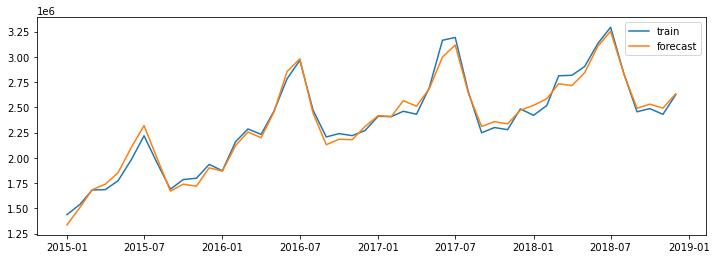

In [64]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train['y'], label='train')
plt.plot(forecast['yhat'][:-12], label='forecast')
plt.legend(loc='best')
plt.show()

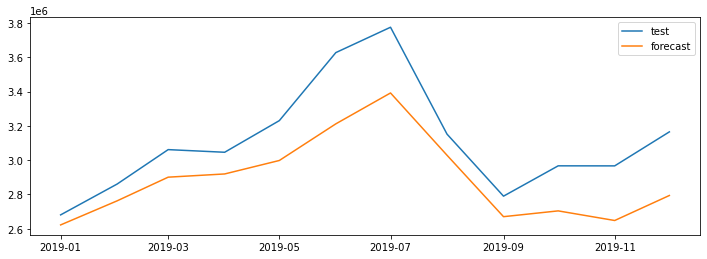

In [65]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['y'], label='test')
plt.plot(forecast['yhat'][-12:], label='forecast')
plt.legend(loc='best')
plt.show()

In [66]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat'][-12:])).round(2)
mape = np.round(np.mean(np.abs(test['y']-forecast['yhat'][-12:])/test['y'])*100,2)
tempResults = pd.DataFrame({'Method':'prophet default', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"


# II. Daily data

# 1. Import and clean data

In [67]:
dom = pd.read_excel('dom.xlsx')

In [68]:
dom.head()

,DATE,Pax
0,2015-01-01,52356
1,2015-01-02,47811
2,2015-01-03,49555
3,2015-01-04,57680
4,2015-01-05,50193


In [69]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2956 non-null   datetime64[ns]
 1   Pax     2956 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.3 KB


In [70]:
dom.set_index('DATE', inplace = True, drop = True)

In [71]:
dom_month = dom.resample('M').sum()

In [72]:
dom_month.tail()

,Pax
DATE,
2022-10-31,3296298
2022-11-30,3181868
2022-12-31,3289334
2023-01-31,3828294
2023-02-28,382182


In [73]:
dom_month.drop('2023-02-28', inplace = True)

In [74]:
dom_train = dom_month[:-12].copy()
dom_test = dom_month[-12:].copy()

In [75]:
# import covid lockdown dummy variable:
lockdown = pd.read_excel('lockdown.xlsx')

In [76]:
lockdown.tail()

,DATE,lockdown
2951,2023-01-30,0
2952,2023-01-31,0
2953,2023-02-01,0
2954,2023-02-02,0
2955,2023-02-03,0


In [77]:
lockdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      2956 non-null   datetime64[ns]
 1   lockdown  2956 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.3 KB


In [78]:
lockdown.set_index('DATE', inplace = True, drop = True)

In [79]:
lockdown_month = lockdown.resample('M').sum()

In [80]:
lockdown_month.drop('2023-02-28', inplace = True)

In [81]:
train_lockdown = lockdown_month[:-12].copy()
test_lockdown = lockdown_month[-12:].copy()

# 2. Time Series Analysis

<AxesSubplot:xlabel='DATE'>

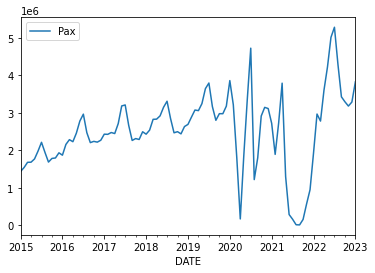

In [82]:
dom_month.plot()

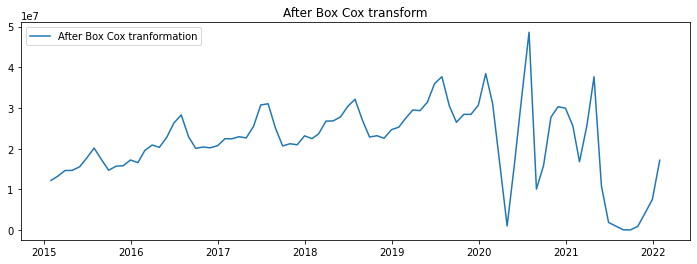

In [83]:
data_boxcox = pd.DataFrame(boxcox(dom_train['Pax'])[0], index = dom_train.index, columns = ['Pax'])

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [84]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -2.139043
Critical Values at 0.05: -2.90
p-value: 0.229108
Not stationary


In [85]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.280032
Critical Values at 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


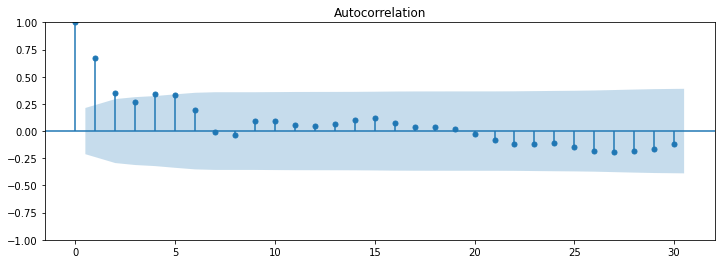

In [86]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


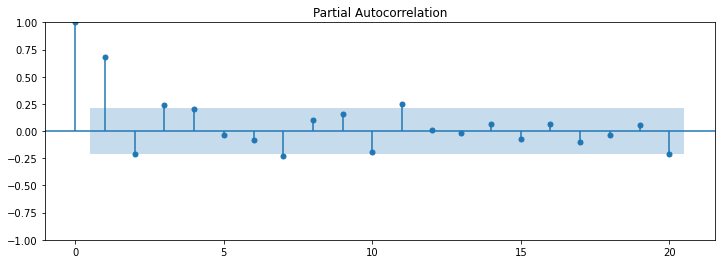

In [87]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox, ax=plt.gca(), lags = 20)
plt.show()

# 3. Build models

## 3.1. SARIMAX with lockdown day as dummy variable

In [88]:
model = auto_arima(data_boxcox,
                   d = None, max_d = 4,
                   start_p = 0,
                   max_p = 7,
                   start_q = 0,
                   max_q = 3,
                   m = 12,
                   seasonal = True,
                   trace = True, random_state = 99, X = train_lockdown)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2856.403, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2855.125, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2858.644, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2858.793, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3142.323, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2856.672, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2856.764, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2857.100, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2857.152, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2850.896, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2852.244, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2852.361, Time=0.14 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2853.423, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2846.238, Time=0.05 sec
 ARIMA(2,1,1)(1,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1417.142
Date:                Wed, 08 Feb 2023   AIC                           2844.284
Time:                        16:17:27   BIC                           2856.438
Sample:                    01-31-2015   HQIC                          2849.170
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lockdown   -7.093e+05   8.79e+04     -8.070      0.000   -8.82e+05   -5.37e+05
ar.L1          0.6816      0.148      4.616      0.000       0.392       0.971
ar.L2         -0.2997      0.069     -4.359      0.000      -0.434      -0.165
ma.L1         -0.7930      0.144     -5.500      0.000      -1.076      -0.510
sigma2      2.871e+13      0.000   7.38e+16      0.000    2.87e+13    2.87e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                22.75
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               9.93   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.92e+32. Standard errors may be unstable.
"""

In [89]:
# Predict using the best model from auto_arima:
dom_test['predict_boxcox'] = pd.Series(model.predict(12, X= test_lockdown).astype('int64'))
dom_test['predict'] = inv_boxcox(dom_test['predict_boxcox'],boxcox(dom_train['Pax'])[1])

In [90]:
dom_test

,Pax,predict_boxcox,predict
DATE,,,
2022-02-28,2968758,20638712,"2,260,700"
2022-03-31,2781311,20131787,"2,212,806"
2022-04-30,3606272,18741593,"2,080,586"
2022-05-31,4224413,17945923,"2,004,300"
2022-06-30,5015042,17820220,"1,992,206"
2022-07-31,5284875,17973005,"2,006,905"
2022-08-31,4297335,18114821,"2,020,532"
2022-09-30,3428134,18165697,"2,025,418"
2022-10-31,3296298,18157872,"2,024,666"


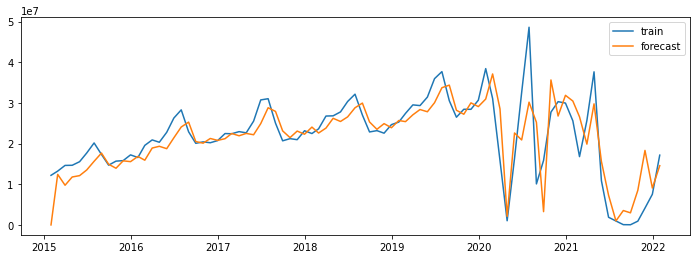

In [91]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='train')
plt.plot(model.predict_in_sample(X = train_lockdown), label='forecast')
plt.legend(loc='best')
plt.show()

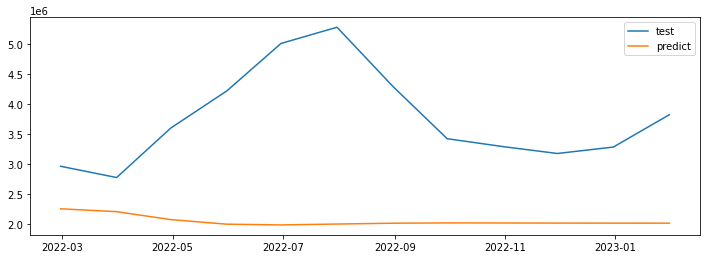

In [92]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(dom_test['Pax'], label='test')
plt.plot(dom_test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [93]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(dom_test['Pax'], dom_test['predict'])).round(2)
mape = np.round(np.mean(np.abs(dom_test['Pax']-dom_test['predict'])/dom_test['Pax'])*100,2)
tempResults = pd.DataFrame({'Method':'ARIMA with boxcox', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"
0,ARIMA with boxcox,43,"1,891,826"


## 3.2. Prophet

In [94]:
dom = pd.read_excel('dom.xlsx')

In [95]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2956 non-null   datetime64[ns]
 1   Pax     2956 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.3 KB


In [96]:
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [97]:
# remove dates in Feb 2023:
dom = dom[dom['ds'] < '2023-02-01']

<AxesSubplot:xlabel='ds'>

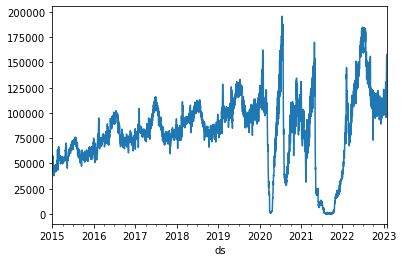

In [98]:
dom.set_index('ds')['y'].plot()

In [99]:
train = dom[dom['ds'] < '2022-01-01'].copy()
test = dom[dom['ds'] >= '2022-01-01'].copy() # 2022 as test set

In [100]:
train

,ds,y
0,2015-01-01,52356
1,2015-01-02,47811
2,2015-01-03,49555
3,2015-01-04,57680
4,2015-01-05,50193
...,...,...
2552,2021-12-27,35727
2553,2021-12-28,37276
2554,2021-12-29,38447
2555,2021-12-30,36736


In [122]:
holidays = pd.read_excel('holidays.xlsx')

In [123]:
holidays

,ds,holiday
0,2020-03-09,covid_1
1,2020-03-10,covid_1
2,2020-03-11,covid_1
3,2020-03-12,covid_1
4,2020-03-13,covid_1
...,...,...
1010,2021-02-17,Lunar
1011,2021-02-18,Lunar
1012,2021-02-19,Lunar
1013,2021-02-20,Lunar


In [267]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

In [268]:
# set the uncertainty interval to 90% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.9, holidays = holidays, changepoints = changepoints, changepoint_prior_scale=0.001)

In [269]:
my_model.fit(train)

17:08:43 - cmdstanpy - INFO - Chain [1] start processing
17:08:43 - cmdstanpy - INFO - Chain [1] done processing


In [270]:
future_dates = my_model.make_future_dataframe(periods=len(test), freq='D')
future_dates.tail()

,ds
2948,2023-01-27
2949,2023-01-28
2950,2023-01-29
2951,2023-01-30
2952,2023-01-31


In [271]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2948,2023-01-27,"148,888","127,328","169,423"
2949,2023-01-28,"145,681","125,170","167,906"
2950,2023-01-29,"150,289","130,475","171,270"
2951,2023-01-30,"147,117","126,253","167,962"
2952,2023-01-31,"143,244","121,381","163,259"


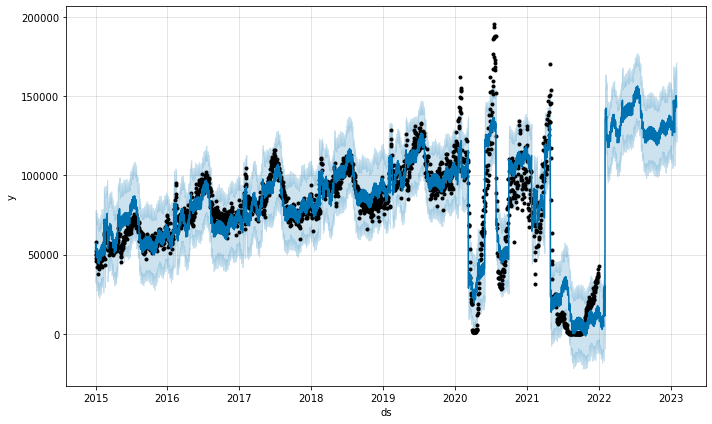

In [272]:
fig = my_model.plot(forecast, uncertainty=True)

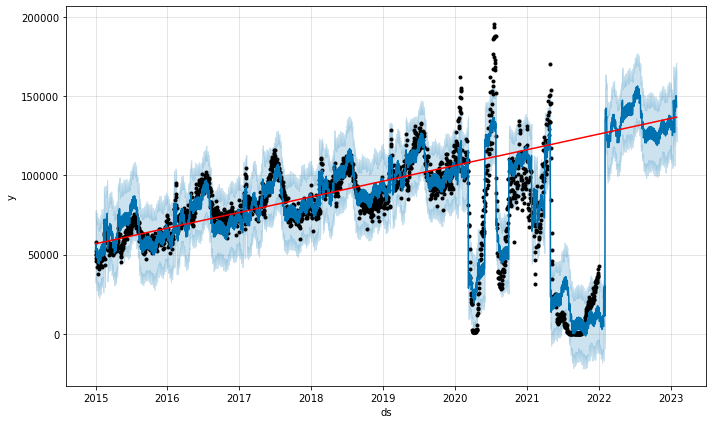

In [273]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [274]:
my_model.changepoints

0   2020-03-09
1   2020-05-31
2   2020-07-28
3   2020-09-30
4   2021-01-25
5   2021-03-31
6   2021-04-30
7   2021-10-22
Name: ds, dtype: datetime64[ns]

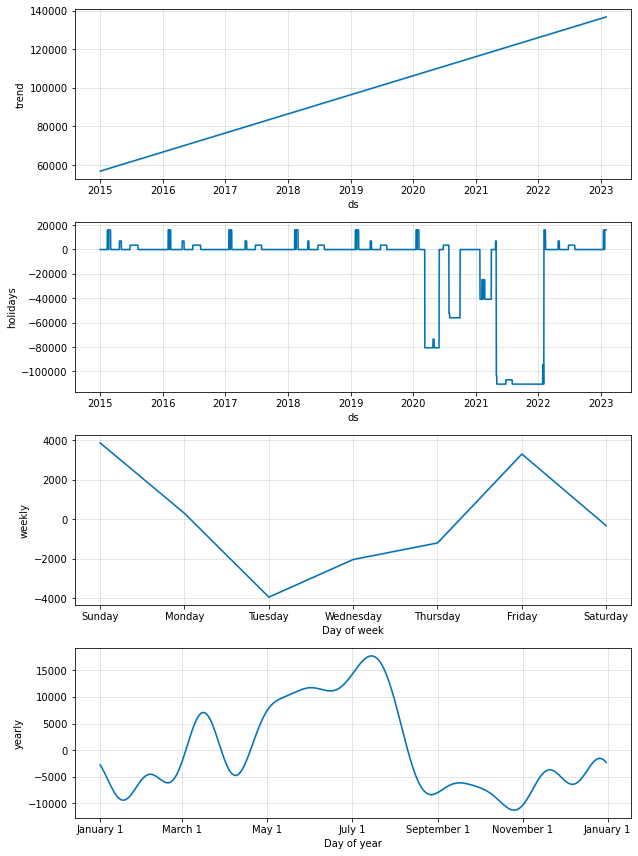

In [275]:
fig2 = my_model.plot_components(forecast)

In [276]:
forecast.set_index('ds',inplace=True)

In [277]:
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Labor,Labor_lower,Labor_upper,Lunar,Lunar_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-01,"56,854","32,465","73,781","56,854","56,854",0,0,0,0,0,...,"-1,194","-1,194","-1,194","-2,566","-2,566","-2,566",0,0,0,"53,094"
2015-01-02,"56,881","35,977","78,193","56,881","56,881",0,0,0,0,0,...,"3,309","3,309","3,309","-2,965","-2,965","-2,965",0,0,0,"57,225"
2015-01-03,"56,908","32,028","72,851","56,908","56,908",0,0,0,0,0,...,-321,-321,-321,"-3,414","-3,414","-3,414",0,0,0,"53,173"
2015-01-04,"56,935","35,194","78,131","56,935","56,935",0,0,0,0,0,...,"3,873","3,873","3,873","-3,906","-3,906","-3,906",0,0,0,"56,902"
2015-01-05,"56,962","31,841","74,458","56,962","56,962",0,0,0,0,0,...,304,304,304,"-4,429","-4,429","-4,429",0,0,0,"52,836"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-27,"136,657","127,328","169,423","136,657","136,657",0,0,0,"16,069","16,069",...,"3,309","3,309","3,309","-7,146","-7,146","-7,146",0,0,0,"148,888"
2023-01-28,"136,684","125,170","167,906","136,684","136,684",0,0,0,"16,069","16,069",...,-321,-321,-321,"-6,751","-6,751","-6,751",0,0,0,"145,681"
2023-01-29,"136,711","130,475","171,270","136,711","136,711",0,0,0,"16,069","16,069",...,"3,873","3,873","3,873","-6,363","-6,363","-6,363",0,0,0,"150,289"


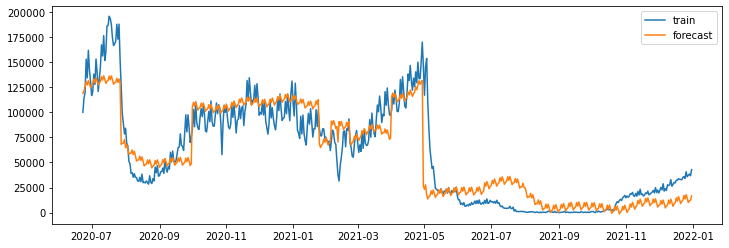

In [278]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train.set_index('ds')['y'][2000:], label='train')
plt.plot(forecast['yhat'][2000:-len(test)], label='forecast')
plt.legend(loc='best')
plt.show()

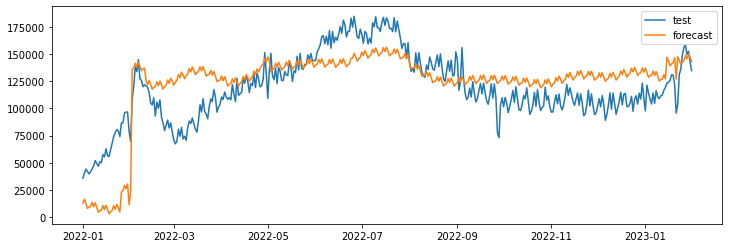

In [279]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test.set_index('ds')['y'], label='test')
plt.plot(forecast['yhat'][-len(test):], label='forecast')
plt.legend(loc='best')
plt.show()

In [252]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test.set_index('ds')['y'], forecast['yhat'][-len(test):])).round(2)
mape = np.round(np.mean(np.abs(test.set_index('ds')['y']-forecast['yhat'][-len(test):])/test.set_index('ds')['y'])*100,2)
tempResults = pd.DataFrame({'Method':'prophet with covid holidays', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"
0,ARIMA with boxcox,43,"1,891,826"
0,prophet default,NaN,"25,658"
0,prophet with covid holidays,21,"25,658"
0,prophet with covid holidays,21,"25,182"
0,prophet with covid holidays,25,"28,299"
0,prophet with covid holidays,23,"26,803"
0,prophet with covid holidays,51,"58,921"
